In [23]:
import numpy as np
import matplotlib.pyplot as plt
from collections import deque
import imageio
from IPython.display import display, Image

## Cellular Potts Model

In [24]:
def plot_timepoint(results, idx):
    """Plot a specific timepoint."""
    if idx < len(results):
        plt.imshow(results[idx], cmap="tab20")
        plt.title(f"Step {idx}")
        plt.show()
    else:
        print(f"Timepoint {idx} not available.")

def lattice_to_image(lattice):
    """Convert lattice to an RGB image for gif creation."""
    fig, ax = plt.subplots()
    ax.imshow(lattice, cmap="tab20")
    ax.axis('off')
    fig.tight_layout()
    
    # Convert the Matplotlib figure to an RGB array
    canvas = plt.get_current_fig_manager().canvas
    canvas.draw()
    img = np.frombuffer(canvas.tostring_rgb(), dtype=np.uint8).reshape(canvas.get_width_height()[::-1] + (3,))
    plt.close(fig)
    return img
    
def generate_gif(results, filename="simulation.gif"):
    """Generate a gif from the results."""
    with imageio.get_writer(filename, mode='I') as writer:
        for lattice in results:
            img = lattice_to_image(lattice)
            writer.append_data(img)

def display_gif(filename):
    """Display the GIF in a Jupyter Notebook."""
    with open(filename, "rb") as f:
        display(Image(data=f.read(), format="png"))


In [19]:
class CPM:
    def __init__(
        self, 
        size=100, 
        adhesion=1, 
        temperature=1, 
        n_cells=10, 
        target_size=10, 
        save_steps=1
    ):
        self.L = size
        self.J = adhesion
        self.T = temperature
        self.n_cells = n_cells
        self.target_size = target_size
        self.save_steps = save_steps

        # initialize
        self.lattice = np.zeros((self.L, self.L), dtype=int)
        self.initialize_cells(target_size=self.target_size)

        # place to save results
        self.results = []

    def initialize_cells(self, target_size=5):
        for cell_id in range(1, self.n_cells+1):
            x, y = np.random.randint(0, self.L, 2)
            
            to_fill = target_size
            cell_sites = [(x, y)]
            self.lattice[x, y] = cell_id
            to_fill -= 1
    
            while to_fill > 0:
                # Randomly choose an existing site from the cell
                xi, yi = cell_sites[np.random.randint(len(cell_sites))]
    
                # Randomly select a neighbor
                dx, dy = [(0, 1), (0, -1), (1, 0), (-1, 0)][np.random.randint(4)]
                xn, yn = (xi + dx) % self.L, (yi + dy) % self.L
    
                if self.lattice[xn, yn] == 0:
                    self.lattice[xn, yn] = cell_id
                    cell_sites.append((xn, yn))
                    to_fill -= 1
    
    def delta_H(self, x, y, xi, yi):
        """Compute the change in Hamiltonian for a copy event."""
        return self.J * (self.lattice[x, y] != self.lattice[xi, yi]) - self.J * (self.lattice[x, y] == self.lattice[xi, yi])

    def metropolis(self, x, y, xi, yi):
        """Use Metropolis criterion to accept or reject a copy event."""
        dH = self.delta_H(x, y, xi, yi)
        if dH < 0:
            return True
        else:
            return np.random.rand() < np.exp(-dH/self.T)

    def run(self, n_steps):
        for step in range(n_steps):
            x, y = np.random.randint(0, self.L, 2)
            direction = np.random.choice(['up', 'down', 'left', 'right'])
            
            if direction == 'up':
                xi, yi = (x, (y+1)%self.L)
            elif direction == 'down':
                xi, yi = (x, (y-1)%self.L)
            elif direction == 'left':
                xi, yi = ((x-1)%self.L, y)
            else:
                xi, yi = ((x+1)%self.L, y)
            
            if self.metropolis(x, y, xi, yi):
                self.lattice[xi, yi] = self.lattice[x, y]

            # Save state
            if step % self.save_steps == 0:
                self.results.append(self.lattice.copy())

    def get_results(self):
        return self.results

In [20]:
cpm = CPM(
    size=50, 
    n_cells=8, 
    save_steps=10,
    target_size=40,
)

cpm.run(1000)

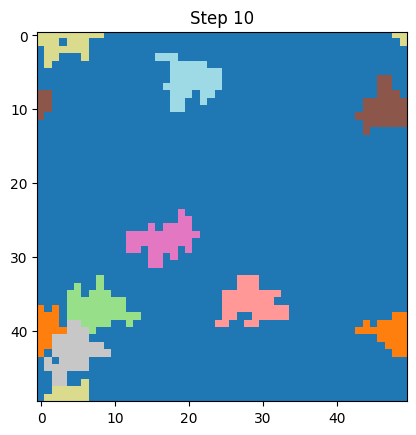

In [21]:
results = cpm.get_results()
idx=10
plot_timepoint(results, idx)

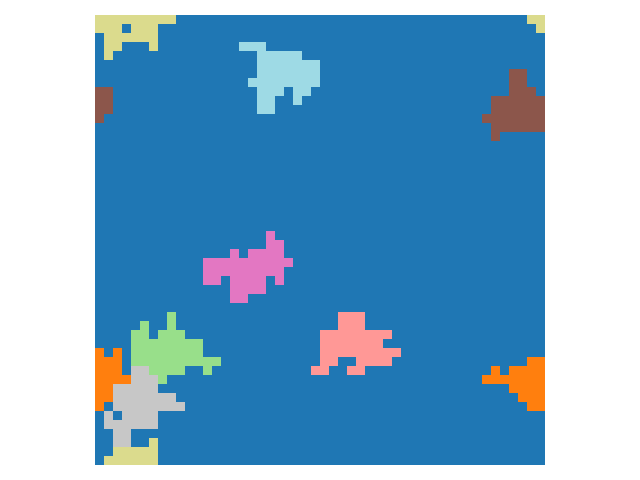

In [25]:
filename = "simulation.gif"
generate_gif(results, filename)
display_gif(filename)